In [ ]:
import numpy as np
import math
from math import sqrt, pi
from functools import partial
import matplotlib.pyplot as plt

from scipy.special import gammaln, logsumexp

# AES SBOX
SBOX = np.array([
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16
], dtype=np.uint8)

def hw8(x: int) -> int:
    return int(bin(x & 0xff).count("1"))

def hw_leakage(keyspace: np.ndarray, v: int) -> np.ndarray:
    keyspace = keyspace.astype(np.uint8)
    return np.array([hw8(SBOX[int(x ^ v)]) for x in keyspace], dtype=float)

In [ ]:

def binary_search_sigma(
    f,
    target,
    left,
    right,
    tol=1e-9,
    max_iter=100,
    max_expand=100,
    expand_factor=2.0,
    min_left=1e-12,
    max_right=1e12,
):
    def g(sigma):
        return f(sigma) - target

    g_left = g(left)
    g_right = g(right)

    if g_left * g_right > 0:
        for _ in range(max_expand):
            new_right = min(right * expand_factor, max_right)
            g_new_right = g(new_right)

            new_left = max(left / expand_factor, min_left)
            g_new_left = g(new_left)

            left, right = new_left, new_right
            g_left, g_right = g_new_left, g_new_right

            if g_left * g_right <= 0:
                break

        if g_left * g_right > 0:
            raise ValueError(
                f"Bisection failed to bracket a root after expansion: "
                f"g(left)={g_left}, g(right)={g_right}, left={left}, right={right}"
            )

    for _ in range(max_iter):
        mid = 0.5 * (left + right)
        g_mid = g(mid)

        if abs(g_mid) <= tol * max(1.0, abs(target)):
            return mid

        if g_left * g_mid <= 0:
            right = mid
            g_right = g_mid
        else:
            left = mid
            g_left = g_mid

    mid = 0.5 * (left + right)
    g_mid = g(mid)
    raise RuntimeError(
        f"Bisection did not converge within max_iter={max_iter}. "
        f"mid={mid}, g(mid)={g_mid}, tol={tol}, "
        f"left={left}, right={right}, g(left)={g_left}, g(right)={g_right}"
    )



In [ ]:
def KL_bernoulli(rho, q1, eps=1e-300):
    rho = float(np.clip(rho, eps, 1.0 - eps))
    q1  = float(np.clip(q1,  eps, 1.0 - eps))
    q2  = 1.0 - q1
    return rho * np.log(rho / q1) + (1.0 - rho) * np.log((1.0 - rho) / q2)

def logD_alpha_KL_rho(rho, alpha, q1, eps=1e-300):
    rho = float(np.clip(rho, eps, 1.0 - eps))
    q1  = float(np.clip(q1,  eps, 1.0 - eps))
    q2  = 1.0 - q1

    alpha = float(alpha)
    logA = np.log(q1) + alpha * (np.log(rho) - np.log(q1))
    logB = np.log(q2) + alpha * (np.log1p(-rho) - np.log(q2))
    return float(logsumexp([logA, logB]))

def invert_rho_from_logD(alpha, q1, log_r_target, iters=500, tol=1e-10, max_expand=200):
    # initial guess
    hi = np.exp((log_r_target + (alpha - 1.0) * np.log(q1)) / alpha)
    hi = min(hi, 1)
    hi= max(hi,q1)
    lo = hi/2
    lo = min(lo, 1)
    lo = max(lo,q1)
    lo = hi/2
    if alpha ==1:
        hi = q1
        lo = q1

    def logD(rho):
        return logD_alpha_KL_rho(rho, alpha, q1)

    log_hi = logD(hi)

    # expand hi until logD(hi) >= target
    if log_hi < log_r_target:
        for _ in range(max_expand):
            hi = (1+hi)/2
            log_hi = logD(hi)
            if log_hi >= log_r_target:
                break
        if log_hi < log_r_target:
            if (1-hi)<1e-10:
                return 1
            raise ValueError(
                f"Failed to bracket target on hi after {max_expand} expansions. "
                f"alpha={alpha}, q1={q1}, log_r_target={log_r_target}, hi={hi}"
            )

    # shrink lo (toward q1) until logD(lo) < target
    log_lo = logD(lo)
    if log_lo > log_r_target:
        for _ in range(max_expand):
            lo = (lo + q1) / 2.0 
            log_lo = logD(lo)
            if log_lo < log_r_target:
                break
        if log_lo >log_r_target:
            print(lo,q1,hi,max_expand)
            raise ValueError(
                f"Failed to bracket target on lo after {max_expand} shrinks. "
                f"alpha={alpha}, q1={q1}, log_r_target={log_r_target}, lo={lo}"
            )

    # bisection
    for i in range(iters):
        mid = 0.5 * (lo + hi)
        log_mid = logD(mid)

        if log_mid >= log_r_target:
            hi = mid
        else:
            lo = mid

        if (hi - lo) <= tol * abs(hi):
            # print("123123",lo,hi)
            break
    if i+1==iters:
        raise ValueError(
            f"iters is not big enough"
        )
    return 0.5 * (lo + hi)

def invert_rho_from_D(alpha, q1, r_target, iters=200, tol=1e-90, max_expand=200):
    if np.isclose(alpha, 1.0):
        # KL is finite-scale; do normal-domain bisection
        target = float(r_target)
        lo, hi = q1, 1.0 - 1e-15

        def f(rho):
            return KL_bernoulli(rho, q1)

        # bracket check
        if f(lo) > target:
            return lo
        if f(hi) < target:
            raise ValueError("Cannot reach target KL within (q1,1).")

        for _ in range(iters):
            mid = 0.5 * (lo + hi)
            if f(mid) >= target:
                hi = mid
            else:
                lo = mid
            if (hi - lo) <= tol * max(1.0, abs(hi)):
                break
        return 0.5 * (lo + hi)

    # alpha>1: use log-domain inversion
    return invert_rho_from_logD(alpha, q1, np.log(float(r_target)), iters=iters, tol=tol, max_expand=max_expand)



In [ ]:
def _log_binom_half_probs(n: int):
    k = np.arange(n + 1, dtype=float)
    logC = gammaln(n + 1) - gammaln(k + 1) - gammaln(n - k + 1)
    logp = logC - n * np.log(2.0)
    return k, logp

def log_my_f(sigma2, alpha, n):
    sigma2 = float(sigma2)
    alpha = float(alpha)
    n = int(n)

    if np.isclose(alpha, 1.0):
        return float(np.log(n / (8.0 * sigma2)))

    if alpha > 1:
        k, logp = _log_binom_half_probs(n)
        c = alpha * (alpha - 1.0) / 2.0
        t = c * ((k - n / 2.0) ** 2) / sigma2
        return float(logsumexp(logp + t))

    raise ValueError("alpha must be >= 1 for my_f")

def my_f(sigma2, alpha, n):
    return float(np.exp(log_my_f(sigma2, alpha, n)))

def gaussian_logpdf(o, mean, sigma2):
    return -0.5*np.log(2.0*np.pi*sigma2) - 0.5*((o-mean)**2)/sigma2

def W_vec_value(o_grid, sigma2, alpha, n):
    o = np.asarray(o_grid, dtype=float).reshape(-1)
    sigma2 = float(sigma2)
    alpha = float(alpha)
    n = int(n)

    k, logp = _log_binom_half_probs(n)                        # (K,), (K,)
    logpdf = gaussian_logpdf(o[:, None], k[None, :], sigma2)  # (M,K)

    if alpha == -1:
        return np.exp(np.max(logpdf, axis=1))

    if np.isclose(alpha, 1.0):
        log_pdf_bar = logsumexp(logp[None, :] + logpdf, axis=1)     # (M,)
        w = np.exp(logp[None, :] + logpdf)                          # (M,K)
        return np.sum(w * (logpdf - log_pdf_bar[:, None]), axis=1)  # (M,)

    raise ValueError("W_vec_value only supports alpha=1 or alpha=-1")


In [ ]:

def integrate_W_value(sigma2, alpha, n, L=12.0, dx=None):
    sigma2 = float(sigma2)
    alpha = float(alpha)
    n = int(n)

    sigma = np.sqrt(sigma2)
    a = 0.0 - L * sigma
    b = float(n) + L * sigma

    if dx is None:
        dx = min(0.05, max(0.002, 0.02 * sigma))

    M = int(np.ceil((b - a) / float(dx))) + 1
    o_grid = np.linspace(a, b, M)

    vals = W_vec_value(o_grid, sigma2, alpha, n)
    return float(np.trapz(vals, o_grid))

def log_integrate_W_alpha_gt_1(sigma2, alpha, n, L=12.0, dx=None):
    sigma2 = float(sigma2)
    alpha = float(alpha)
    n = int(n)

    sigma = np.sqrt(sigma2)
    a = 0.0 - L * sigma
    b = float(n) + L * sigma

    if dx is None:
        dx = min(0.05, max(0.002, 0.02 * sigma))

    M = int(np.ceil((b - a) / float(dx))) + 1
    o_grid = np.linspace(a, b, M)

    k, logp = _log_binom_half_probs(n)                        # (K,), (K,)
    logpdf = gaussian_logpdf(o_grid[:, None], k[None, :], sigma2)  # (M,K)

    logS = logsumexp(logp[None, :] + alpha * logpdf, axis=1)  # (M,)
    logW = logS / alpha                                       # (M,)

    return float(logsumexp(logW) + np.log((b - a) / (M - 1)))




In [ ]:
def plot_n_q1(n=16, q1=None):
    if q1 is None:
        q1 = 2.0 ** (-int(n))

    left = 100
    right = 1000
    N = 200
    iflog = 1

    sigma2_list = np.linspace(left, right, N)

    alpha = 1
    rho_list = []
    for sigma2 in sigma2_list:
        r = integrate_W_value(sigma2, alpha=1, n=n, L=12)
        rho = invert_rho_from_D(alpha=1, q1=q1, r_target=r)
        rho_list.append(rho)

    rho_arr = np.array(rho_list, float)
    if iflog:
        rho_arr = np.log2(rho_arr)

    plt.figure()
    plt.plot(sigma2_list, rho_arr, label="Mutual Information")
    plt.xlabel(r"$\sigma^2$")
    plt.ylabel(r"$\log_2(\rho)$" if iflog else r"$\rho$")
    plt.legend()
    plt.grid(True)

    # --- alpha = 10 , W is gaussian ---
    alpha = 10
    rho_list = []
    for sigma2 in sigma2_list:
        log_r = log_my_f(sigma2, alpha, n)  # log-domain safe
        rho = invert_rho_from_logD(alpha=alpha, q1=q1, log_r_target=log_r)
        rho_list.append(rho)

    rho_arr = np.array(rho_list, float)
    if iflog:
        rho_arr = np.log2(rho_arr)

    plt.plot(sigma2_list, rho_arr, label=f"alpha = {alpha} (PAC)")
    plt.legend()
    plt.grid(True)

    # --- alpha = 10 and W is best (log integral) ---
    alpha = 10
    rho_list = []
    for sigma2 in sigma2_list:
        log_I = log_integrate_W_alpha_gt_1(sigma2, alpha, n, L=8)
        log_r = alpha * log_I
        rho = invert_rho_from_logD(alpha=alpha, q1=q1, log_r_target=log_r)
        rho_list.append(rho)

    rho_arr = np.array(rho_list, float)
    if iflog:
        rho_arr = np.log2(rho_arr)

    plt.plot(sigma2_list, rho_arr, label=f"real alpha = {alpha} (optimal W)")
    plt.legend()
    plt.grid(True)

    # --- alpha = infinity (alpha=-1 max-case) ---
    alpha = -1
    rho_list = []
    for sigma2 in sigma2_list:
        r = integrate_W_value(sigma2, alpha=-1, n=n, L=12)
        rho = q1 * r
        rho_list.append(rho)

    rho_arr = np.array(rho_list, float)
    if iflog:
        rho_arr = np.log2(rho_arr)

    plt.plot(sigma2_list, rho_arr, label="real case (alpha = infinity, via max)")
    plt.legend()
    plt.grid(True)
    plt.show()


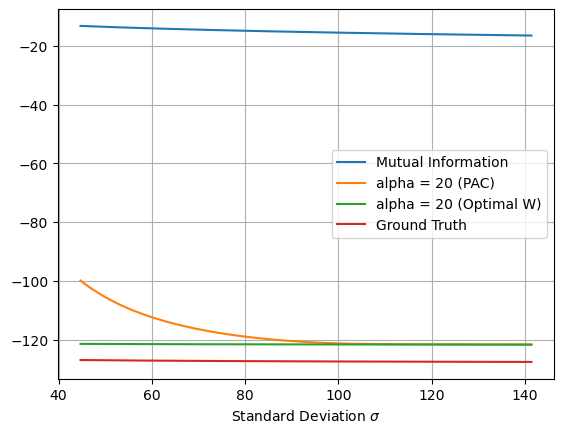

In [34]:

"128 bit indentical"
n = 128
q1 = 2.0 ** (-int(n))

left = 2000
right = 20000
N = 200
iflog = 1

sigma2_list = np.linspace(left, right, N)
sigma_list = np.sqrt(sigma2_list)

# alpha = 1 (value domain)
alpha = 1
rho_list = []
for sigma2 in sigma2_list:
    r = integrate_W_value(sigma2, alpha=1, n=n, L=12)
    rho = invert_rho_from_D(alpha=1, q1=q1, r_target=r)
    rho_list.append(rho)

rho_arr = np.array(rho_list, float)
if iflog:
    rho_arr = np.log2(rho_arr)

plt.figure()
plt.plot(sigma_list, rho_arr, label="Mutual Information")
plt.xlabel(r"Standard Deviation $ \sigma$")
# plt.ylabel(r"$\log_2(\rho)$" if iflog else r"$\rho$")
plt.legend()
plt.grid(True)

# alpha = 40, gaussian bound (log domain)
alpha = 20
rho_list = []
for sigma2 in sigma2_list:
    log_r = log_my_f(sigma2, alpha, n)
    rho = invert_rho_from_logD(alpha=alpha, q1=q1, log_r_target=log_r)
    rho_list.append(rho)

rho_arr = np.array(rho_list, float)
if iflog:
    rho_arr = np.log2(rho_arr)

plt.plot(sigma_list, rho_arr, label=f"alpha = {alpha} (PAC)")
plt.legend()
plt.grid(True)

# alpha = 40, best W (log integral)
alpha = 20
rho_list = []
for sigma2 in sigma2_list:
    log_I = log_integrate_W_alpha_gt_1(sigma2, alpha, n, L=8)
    log_r = alpha * log_I
    rho = invert_rho_from_logD(alpha=alpha, q1=q1, log_r_target=log_r)
    rho_list.append(rho)

rho_arr = np.array(rho_list, float)
if iflog:
    rho_arr = np.log2(rho_arr)

plt.plot(sigma_list, rho_arr, label=f"alpha = {alpha} (Optimal W)")
plt.legend()
plt.grid(True)

# alpha = infinity (alpha=-1)
alpha = -1
rho_list = []
for sigma2 in sigma2_list:
    r = integrate_W_value(sigma2, alpha=-1, n=n, L=12)
    rho = q1 * r
    rho_list.append(rho)

rho_arr = np.array(rho_list, float)
if iflog:
    rho_arr = np.log2(rho_arr)

plt.plot(sigma_list, rho_arr, label="Ground Truth")
plt.legend()
plt.grid(True)
plt.savefig("128bit_identical.png")
plt.show()

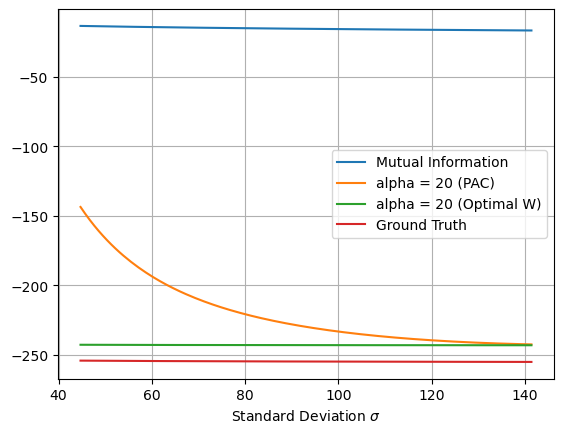

In [35]:

"256 bit indentical"
n = 256
q1 = 2.0 ** (-int(n))

left = 2000
right = 20000
N = 200
iflog = 1

sigma2_list = np.linspace(left, right, N)
sigma_list = np.sqrt(sigma2_list)

# alpha = 1 (value domain)
alpha = 1
rho_list = []
for sigma2 in sigma2_list:
    r = integrate_W_value(sigma2, alpha=1, n=n, L=12)
    rho = invert_rho_from_D(alpha=1, q1=q1, r_target=r)
    rho_list.append(rho)

rho_arr = np.array(rho_list, float)
if iflog:
    rho_arr = np.log2(rho_arr)

plt.figure()
plt.plot(sigma_list, rho_arr, label="Mutual Information")
plt.xlabel(r"Standard Deviation $ \sigma$")
# plt.ylabel(r"$\log_2(\rho)$" if iflog else r"$\rho$")
plt.legend()
plt.grid(True)

# alpha = 40, gaussian bound (log domain)
alpha = 20
rho_list = []
for sigma2 in sigma2_list:
    log_r = log_my_f(sigma2, alpha, n)
    rho = invert_rho_from_logD(alpha=alpha, q1=q1, log_r_target=log_r)
    rho_list.append(rho)

rho_arr = np.array(rho_list, float)
if iflog:
    rho_arr = np.log2(rho_arr)

plt.plot(sigma_list, rho_arr, label=f"alpha = {alpha} (PAC)")
plt.legend()
plt.grid(True)

# alpha = 40, best W (log integral)
alpha = 20
rho_list = []
for sigma2 in sigma2_list:
    log_I = log_integrate_W_alpha_gt_1(sigma2, alpha, n, L=8)
    log_r = alpha * log_I
    rho = invert_rho_from_logD(alpha=alpha, q1=q1, log_r_target=log_r)
    rho_list.append(rho)

rho_arr = np.array(rho_list, float)
if iflog:
    rho_arr = np.log2(rho_arr)

plt.plot(sigma_list, rho_arr, label=f"alpha = {alpha} (Optimal W)")
plt.legend()
plt.grid(True)

# alpha = infinity (alpha=-1)
alpha = -1
rho_list = []
for sigma2 in sigma2_list:
    r = integrate_W_value(sigma2, alpha=-1, n=n, L=12)
    rho = q1 * r
    rho_list.append(rho)

rho_arr = np.array(rho_list, float)
if iflog:
    rho_arr = np.log2(rho_arr)

plt.plot(sigma_list, rho_arr, label="Ground Truth")
plt.legend()
plt.grid(True)
# plt.title("256bit identical")
plt.savefig("256bit_identical.png")
plt.show()

In [ ]:
def log_prior_success_prob(n: int, k: int) -> float:
    if n < 0:
        raise ValueError("n must be nonnegative")
    if k < 0:
        return float("-inf")
    if k >= n:
        return 0.0  # log(1)

    log_terms = [math.lgamma(n + 1) - math.lgamma(i + 1) - math.lgamma(n - i + 1)
                 for i in range(k + 1)]
    m = max(log_terms)
    s = sum(math.exp(t - m) for t in log_terms)
    log_sumC = m + math.log(s)
    return float(log_sumC - n * math.log(2.0))

log_sr = log_prior_success_prob(128, 16)
sr = math.exp(log_sr)
print(sr)

3.189612506824401e-19


3.189612506824401e-19


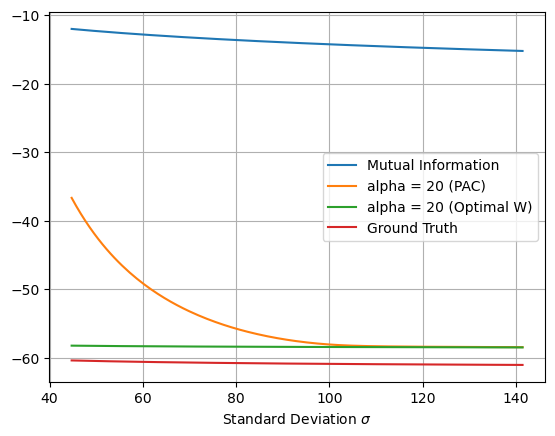

In [37]:

"128 bit miss 16 "
n = 128
log_sr = log_prior_success_prob(n, 16)
sr = math.exp(log_sr)
print(sr)
q1 = sr

left = 2000
right = 20000
N = 200
iflog = 1

sigma2_list = np.linspace(left, right, N)
sigma_list = np.sqrt(sigma2_list)

# alpha = 1 (value domain)
alpha = 1
rho_list = []
for sigma2 in sigma2_list:
    r = integrate_W_value(sigma2, alpha=1, n=n, L=12)
    rho = invert_rho_from_D(alpha=1, q1=q1, r_target=r)
    rho_list.append(rho)

rho_arr = np.array(rho_list, float)
if iflog:
    rho_arr = np.log2(rho_arr)

plt.figure()
plt.plot(sigma_list, rho_arr, label="Mutual Information")
plt.xlabel(r"Standard Deviation $ \sigma$")
# plt.ylabel(r"$\log_2(\rho)$" if iflog else r"$\rho$")
plt.legend()
plt.grid(True)

# alpha = 40, gaussian bound (log domain)
alpha = 20
rho_list = []
for sigma2 in sigma2_list:
    log_r = log_my_f(sigma2, alpha, n)
    rho = invert_rho_from_logD(alpha=alpha, q1=q1, log_r_target=log_r)
    rho_list.append(rho)

rho_arr = np.array(rho_list, float)
if iflog:
    rho_arr = np.log2(rho_arr)

plt.plot(sigma_list, rho_arr, label=f"alpha = {alpha} (PAC)")
plt.legend()
plt.grid(True)

# alpha = 40, best W (log integral)
alpha = 20
rho_list = []
for sigma2 in sigma2_list:
    log_I = log_integrate_W_alpha_gt_1(sigma2, alpha, n, L=8)
    log_r = alpha * log_I
    rho = invert_rho_from_logD(alpha=alpha, q1=q1, log_r_target=log_r)
    rho_list.append(rho)

rho_arr = np.array(rho_list, float)
if iflog:
    rho_arr = np.log2(rho_arr)

plt.plot(sigma_list, rho_arr, label=f"alpha = {alpha} (Optimal W)")
plt.legend()
plt.grid(True)

# alpha = infinity (alpha=-1)
alpha = -1
rho_list = []
for sigma2 in sigma2_list:
    r = integrate_W_value(sigma2, alpha=-1, n=n, L=12)
    rho = q1 * r
    rho_list.append(rho)

rho_arr = np.array(rho_list, float)
if iflog:
    rho_arr = np.log2(rho_arr)

plt.plot(sigma_list, rho_arr, label="Ground Truth")
plt.legend()
plt.grid(True)
plt.savefig("128bit_miss16.png")
plt.show()

In [38]:
log_sr = log_prior_success_prob(256, 16)
sr = math.exp(log_sr)
print(sr)

9.32004825991934e-53


9.32004825991934e-53


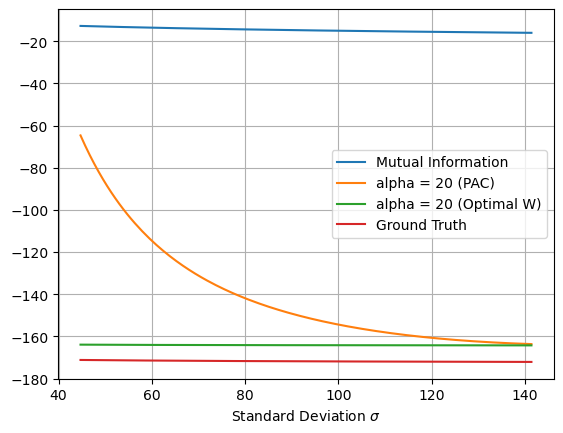

In [39]:

"256 bit miss 16 "
n = 256
log_sr = log_prior_success_prob(n, 16)
sr = math.exp(log_sr)
print(sr)
q1 = sr

left = 2000
right = 20000
N = 200
iflog = 1

sigma2_list = np.linspace(left, right, N)
sigma_list = np.sqrt(sigma2_list)

# alpha = 1 (value domain)
alpha = 1
rho_list = []
for sigma2 in sigma2_list:
    r = integrate_W_value(sigma2, alpha=1, n=n, L=12)
    rho = invert_rho_from_D(alpha=1, q1=q1, r_target=r)
    rho_list.append(rho)

rho_arr = np.array(rho_list, float)
if iflog:
    rho_arr = np.log2(rho_arr)

plt.figure()
plt.plot(sigma_list, rho_arr, label="Mutual Information")
plt.xlabel(r"Standard Deviation $ \sigma$")
# plt.ylabel(r"$\log_2(\rho)$" if iflog else r"$\rho$")
plt.legend()
plt.grid(True)

# alpha = 40, gaussian bound (log domain)
alpha = 20
rho_list = []
for sigma2 in sigma2_list:
    log_r = log_my_f(sigma2, alpha, n)
    rho = invert_rho_from_logD(alpha=alpha, q1=q1, log_r_target=log_r)
    rho_list.append(rho)

rho_arr = np.array(rho_list, float)
if iflog:
    rho_arr = np.log2(rho_arr)

plt.plot(sigma_list, rho_arr, label=f"alpha = {alpha} (PAC)")
plt.legend()
plt.grid(True)

# alpha = 40, best W (log integral)
alpha = 20
rho_list = []
for sigma2 in sigma2_list:
    log_I = log_integrate_W_alpha_gt_1(sigma2, alpha, n, L=8)
    log_r = alpha * log_I
    rho = invert_rho_from_logD(alpha=alpha, q1=q1, log_r_target=log_r)
    rho_list.append(rho)

rho_arr = np.array(rho_list, float)
if iflog:
    rho_arr = np.log2(rho_arr)

plt.plot(sigma_list, rho_arr, label=f"alpha = {alpha} (Optimal W)")
plt.legend()
plt.grid(True)

# alpha = infinity (alpha=-1)
alpha = -1
rho_list = []
for sigma2 in sigma2_list:
    r = integrate_W_value(sigma2, alpha=-1, n=n, L=12)
    rho = q1 * r
    rho_list.append(rho)

rho_arr = np.array(rho_list, float)
if iflog:
    rho_arr = np.log2(rho_arr)

plt.plot(sigma_list, rho_arr, label="Ground Truth")
plt.legend()
plt.grid(True)
plt.savefig("256bit_miss16.png")
plt.show()

In [ ]:
import math
import numpy as np
def log_prior_success_prob(n: int, k: int) -> float:
    if n < 0:
        raise ValueError("n must be nonnegative")
    if k < 0:
        return float("-inf")
    if k >= n:
        return 0.0  # log(1)

    log_terms = [math.lgamma(n + 1) - math.lgamma(i + 1) - math.lgamma(n - i + 1)
                 for i in range(k + 1)]
    m = max(log_terms)
    s = sum(math.exp(t - m) for t in log_terms)
    log_sumC = m + math.log(s)
    return float(log_sumC - n * math.log(2.0))

log_sr = log_prior_success_prob(251, 16)
sr = math.exp(log_sr)
print(sr)
alpha = 5
print((alpha-1)*np.log2(1/sr)/alpha)



2.157385168996132e-51
134.64723925443624


In [41]:
log_sr = log_prior_success_prob(256, 16)
sr = math.exp(log_sr)
print(sr)
alpha = 5
print((alpha-1)*np.log2(1/sr)/alpha)

9.32004825991934e-53
138.27348128299724
